## STORING Normalized DATA IN THE MONGO DATABASE

In [ ]:
import os
import librosa
import numpy as np
import pymongo
from pymongo import MongoClient
from mutagen.easyid3 import EasyID3
from mutagen.mp3 import MP3
from concurrent.futures import ThreadPoolExecutor

In [ ]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['music_database']
collection = db['test']

In [ ]:
def Normalization(data):
    return (data - np.mean(data)) / np.std(data)

def Standardization(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    if std_dev == 0:
        return np.zeros_like(data)
    else:
        return (data - mean) / std_dev

In [ ]:
def extract_audio_features(file_path):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, sr=None)
        
        Normalized_mfccs = []
        # Extract MFCCs
        mfccs = (librosa.feature.mfcc(y=audio, sr=sample_rate)).tolist()
        for data in mfccs:
            mfccs_array = np.array(data)
            Normalized_mfccs.append(Standardization(mfccs_array).tolist())
        
        # Extract Spectral Centroid
        spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sample_rate).tolist()
        spectral_centroids_array = np.array(spectral_centroids)
        Normalized_spectral_centroids = Standardization(spectral_centroids_array).tolist()

        # Extract Zero Crossing Rate                                                                         
        zero_crossings = librosa.feature.zero_crossing_rate(y=audio).tolist()
        zero_crossings_array = np.array(zero_crossings)
        Normalized_zero_crossings = Normalization(zero_crossings_array).tolist()

        return {
            "normalized_mfccs": Normalized_mfccs,
            "normalized_spectral_centroids": Normalized_spectral_centroids,
            "normalized_zero_crossings": Normalized_zero_crossings,
        }
    
    except Exception as e:
        print(f'Error: {e}')
        return None
    

def extract_metadata(file_path):
    try:
        audio = MP3(file_path, ID3=EasyID3)
        return {
            "title": audio.get("title", ["Unknown"])[0],
            "artist": audio.get("artist", ["Unknown"])[0],
            "album": audio.get("album", ["Unknown"])[0],
            "genre": audio.get("genre", ["Unknown"])[0],
            "track_number": audio.get("tracknumber", ["Unknown"])[0]
        }
    except Exception as e:
        print(f'Error: {e}')
        return None


In [ ]:
def process_file(file_path):
    # Extract metadata and features
    metadata = extract_metadata(file_path)
    features = extract_audio_features(file_path)

    if metadata is None or features is None:
        return

    else:
         # Combine data
        data = {**metadata, **features}
        
        # Print the combined data
        # print(f"Data for {file_path}: {data}")
        
        # Insert into MongoDB
        collection.insert_one(data)

def process_audio_files(base_folder):
    # Prepare a list of all mp3 files to be processed
    file_paths = []
    for subdir, dirs, files in os.walk(base_folder):
        for file in files:
            if file.endswith('.mp3'):
                file_paths.append(os.path.join(subdir, file))
    
    # Process files in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=12) as executor:
        executor.map(process_file, file_paths)

In [ ]:
# Specify the path to the base directory containing all subfolders
base_folder = 'Spotify'  # Adjust this path to your setup
process_audio_files(base_folder)

## Getting the PCA Accurate n_components value for each feature

In [ ]:
import os
import librosa
import numpy as np
from mutagen.easyid3 import EasyID3
from mutagen.mp3 import MP3
from concurrent.futures import ThreadPoolExecutor
import pymongo
from pymongo import MongoClient
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

In [ ]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['music_database']
collection = db['processed_metadata_features']

In [ ]:
def Normalization(data):
    return (data - np.mean(data)) / np.std(data)

def Standardization(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

In [ ]:
def transformation(data):
    # Apply Discrete Cosine Transform
    transformed_data = dct(data, norm='ortho')
    # Reduce the dimension by keeping only the first 100 coefficients
    reduced_data = np.zeros_like(transformed_data)
    num_coefficients = 500
    reduced_data[:num_coefficients] = transformed_data[:num_coefficients]
    # Inverse DCT to reconstruct the signal from the reduced data
    reconstructed_data = idct(reduced_data, norm='ortho')
    
    return reconstructed_data

def dimensionality_reduction(data):
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    # Apply PCA
    pca = PCA(n_components=10)
    principal_components = pca.fit_transform(data)

    return principal_components

def reverse_shape(data):
    # Get the current shape
    current_shape = data.shape
    # Reverse the shape
    reversed_shape = tuple(reversed(current_shape))
    # Reshape the array with the reversed shape
    reversed_data = np.reshape(data, reversed_shape)
    
    return reversed_data

In [ ]:
def processed_features_exraction(file_path):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, sr=None)
        
        # Extract MFCCs
        mfccs = (librosa.feature.mfcc(y=audio, sr=sample_rate))

        # Apply PCA
        # Normalized_mfccs = Standardization(mfccs).tolist()
        PCA_mfccs = dimensionality_reduction(mfccs).tolist()

        mfccs = reverse_shape(mfccs)
        PCA_Normalized_mfccs = dimensionality_reduction(mfccs)
        PCA_Normalized_mfccs = reverse_shape(PCA_Normalized_mfccs).tolist()

        # Extract Spectral Centroid
        spectral_centroids_array = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
        spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sample_rate).tolist()
        Normalized_spectral_centroids = Standardization(spectral_centroids_array).tolist()

        # Apply PCA
        PCA_Normalized_spectral_centroids = transformation(spectral_centroids).tolist()

        # Extract Zero Crossing Rate                                                                         
        zero_crossings_array = librosa.feature.zero_crossing_rate(y=audio)
        zero_crossings = librosa.feature.zero_crossing_rate(y=audio).tolist()
        Normalized_zero_crossings = Normalization(zero_crossings_array).tolist()

        # Apply PCA
        PCA_Normalized_zero_crossings = transformation(zero_crossings_array).tolist()

        return {
            "pca_mfccs": PCA_mfccs,
            "pca_normalized_mfccs": PCA_Normalized_mfccs,
            "pca_normalized_spectral_centroids": PCA_Normalized_spectral_centroids,
            "pca_normalized_zero_crossings": PCA_Normalized_zero_crossings,
            "normalized_zero_crossings": Normalized_zero_crossings,
        }
    
    except Exception as e:
        print(f'Error: {e}')
        return None
    

def extract_metadata(file_path):
    try:
        audio = MP3(file_path, ID3=EasyID3)
        return {
            "title": audio.get("title", ["Unknown"])[0],
            "artist": audio.get("artist", ["Unknown"])[0],
            "album": audio.get("album", ["Unknown"])[0],
            "genre": audio.get("genre", ["Unknown"])[0],
            "track_number": audio.get("tracknumber", ["Unknown"])[0]
        }
    except Exception as e:
        print(f'Error: {e}')
        return None

In [ ]:
def process_file(file_path):
    # Extract metadata and features
    metadata = extract_metadata(file_path)
    features = processed_features_exraction(file_path)

    if metadata is None or features is None:
        print(f"Error processing {file_path}")
        return
    else:
         # Combine data
        data = {**metadata, **features}
        
        # Print the combined data
        # print(f"Data for {file_path}: {data}")
        
        # Insert into MongoDB
        collection.insert_one(data)

def process_audio_files(base_folder):
    # Prepare a list of all mp3 files to be processed
    file_paths = []
    for subdir, dirs, files in os.walk(base_folder):
        for file in files:
            if file.endswith('.mp3'):
                file_paths.append(os.path.join(subdir, file))
    
    # Process files in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=12) as executor:
        executor.map(process_file, file_paths)

In [ ]:
# Specify the path to the base directory containing all subfolders
base_folder = 'Spotify'  # Adjust this path to your setup
process_audio_files(base_folder)

## Using PySpark For Model Training

In [1]:
import os
import librosa
import numpy as np
import pymongo
from pymongo import MongoClient
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
spark = SparkSession.builder \
    .appName("Music Data Loading") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/music_database.processed_metadata_features") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/music_database.processed_metadata_features") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()


# Load data from MongoDB
df = spark.read.format("mongo").load()

# Show the DataFrame schema and some entries to verify the load
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- album: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- normalized_zero_crossings: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- pca_mfccs: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- pca_normalized_mfccs: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- pca_normalized_spectral_centroids: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- pca_normalized_zero_crossings: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- title: string (nullable = true)


In [3]:
mfccs = df.select("pca_mfccs").collect()

In [4]:
titles = df.select("title").collect()

In [5]:
artist = df.select("artist").collect()

In [6]:
album = df.select("album").collect()

In [7]:
genre = df.select("genre").collect()

In [8]:
track_number = df.select("track_number").collect()

In [9]:
# For the mean of MFCCS
processed_data = []

for mfcc in mfccs:
    for i in mfcc:
     for j in i:
        processed_data.append(np.mean(j))

processed_data = np.array(processed_data)
processed_data.shape

data = np.reshape(processed_data, (106399, 20))
data.shape

# pca = PCA(n_components=5)
# data = pca.fit_transform(data)

data.shape

(106399, 20)

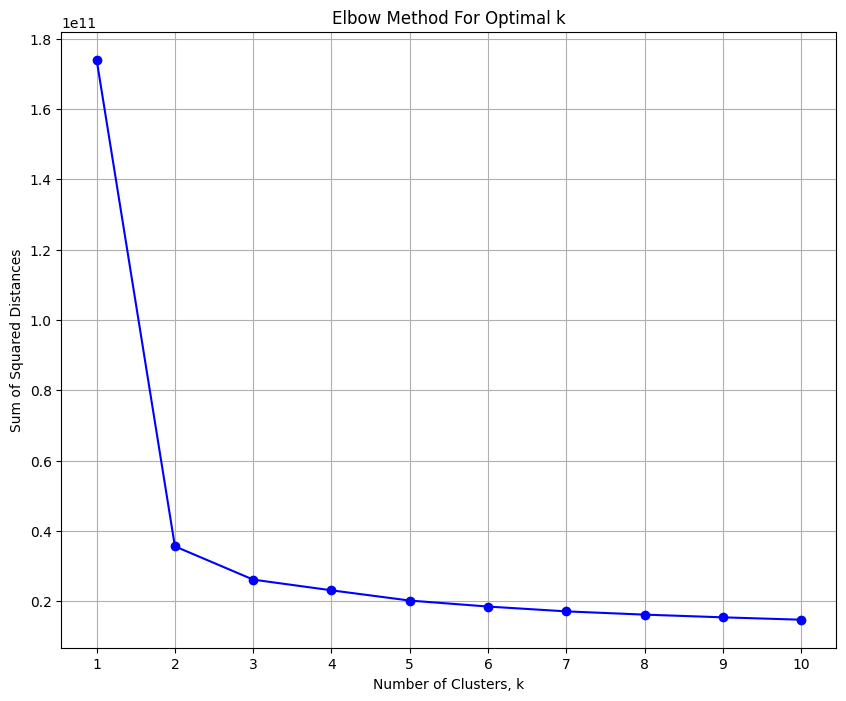

In [10]:
# Calculate sum of squared distances for different numbers of clusters
inertias = []
ks = range(1, 11)  # Testing 1 to 10 clusters
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 8))
plt.plot(ks, inertias, 'bo-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(ks)
plt.grid(True)
plt.show()

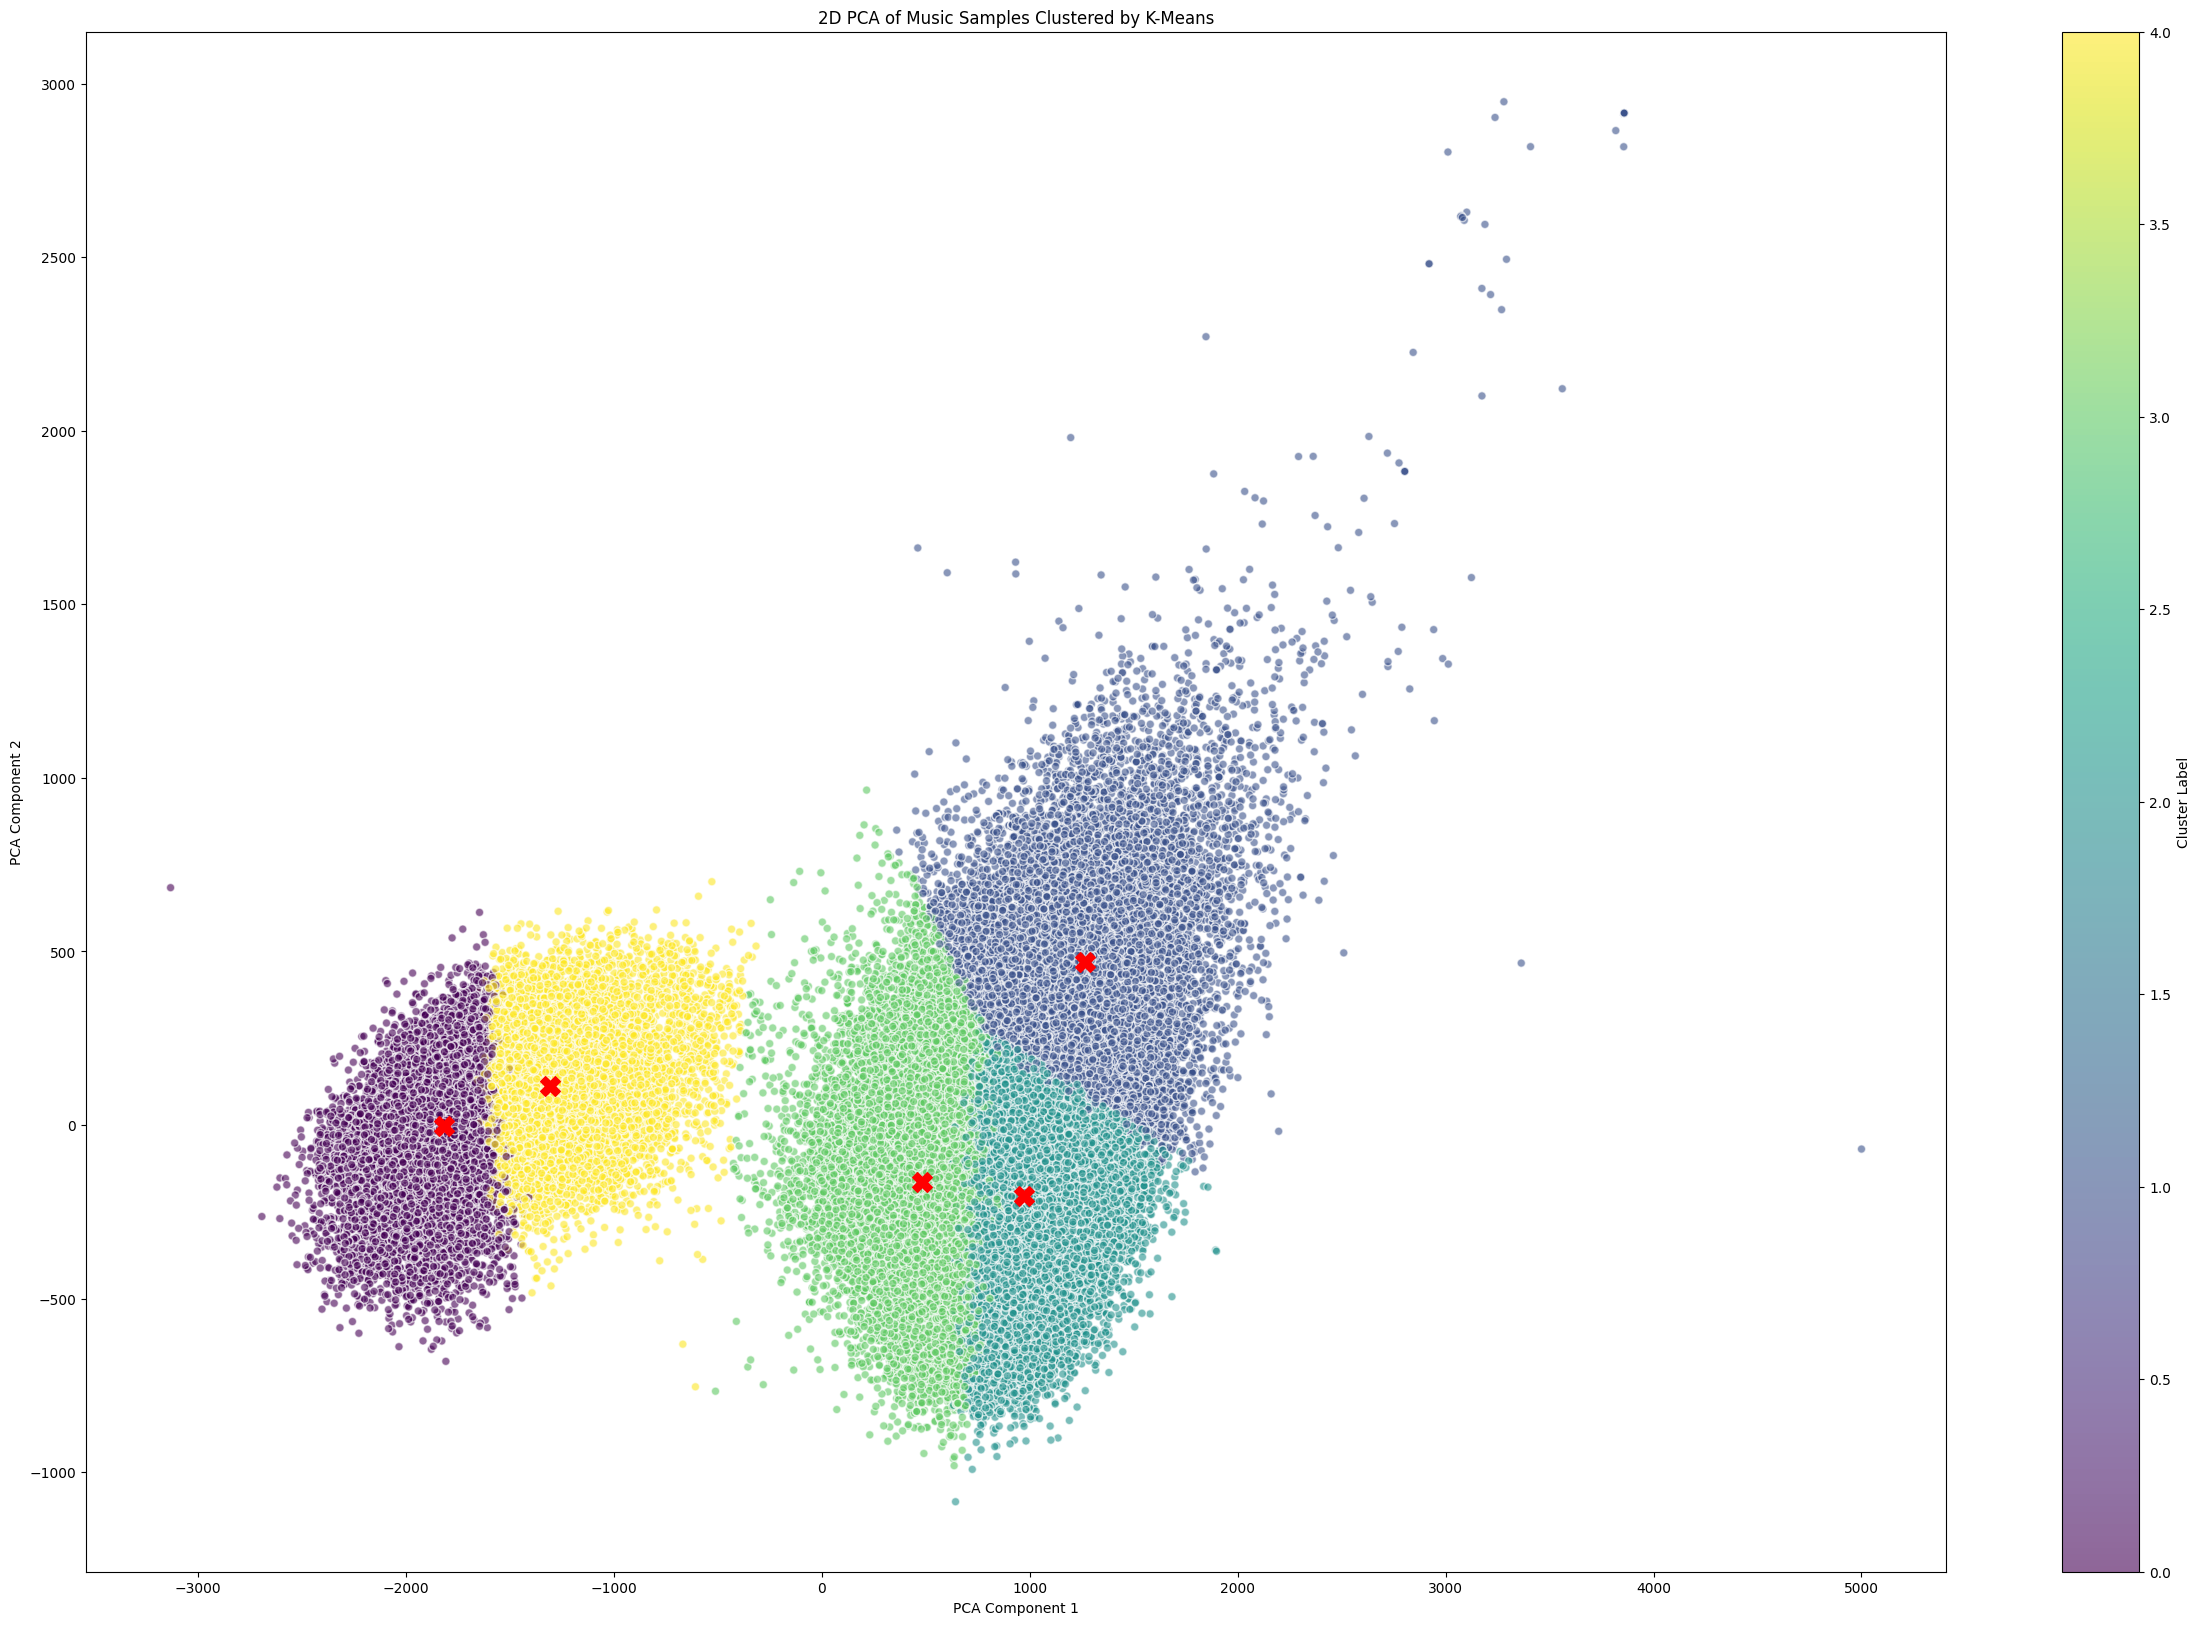

In [11]:
# Number of clusters
k = 5  # Adjust based on your analysis

# Initialize the KMeans algorithm
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit the model to the data
kmeans.fit(data)

# Predict the cluster labels
labels = kmeans.labels_

# Cluster centers
centers = kmeans.cluster_centers_

# Reduce data to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)
reduced_centers = pca.transform(centers)

# Plotting
plt.figure(figsize=(30, 20))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.6, edgecolors='w')
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='red', s=200, marker='X')  # Mark the cluster centers
plt.title('2D PCA of Music Samples Clustered by K-Means')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

In [12]:
print("clusters: ", kmeans.cluster_centers_)

clusters:  [[-708.49111573  991.26352292 -197.74456498  189.63379506  -12.29605656
    79.15642554  -39.80920501   20.27171571  -31.69767764   -4.91346024
   -31.99796635  -15.52852229  -30.06128739  -20.36343887  -28.79405163
   -28.94454099  -33.74574255  -33.73909354  -29.7284166   -32.47031352]
 [1968.93888944 -566.16112977 -155.0044394  -113.76128501  -94.00030317
   -84.86793416  -69.2032923   -76.13678796  -69.67569076  -67.16010941
   -66.29302427  -69.3262481   -63.0246526   -64.32289436  -64.38204682
   -68.24776413  -69.21100952  -72.65265228  -69.1177135   -66.38993267]
 [1344.01414489 -881.99447008   12.03685063  -61.5307604   -69.29160799
   -29.61844464  -23.63867712  -25.54163507  -27.17058551  -16.71284836
   -21.46160524  -20.68104371  -21.24359374  -19.51113389  -20.98426246
   -21.57762949  -22.88822789  -24.22878043  -25.6644971   -22.31119496]
 [ 999.24649955 -500.12208219   71.60866858 -117.57824857   -6.95837459
   -47.98067415  -12.47718843  -39.20420504  -25.7

In [13]:
# Save data in a text file
np.savetxt('new_cluster_centers.txt', kmeans.cluster_centers_)

In [17]:
# Load cluster centers from the uploaded file
cluster_centers = np.loadtxt('new_cluster_centers.txt')

# Function to assign clusters
def assign_clusters(data, centers):
    # Calculate the squared Euclidean distance to each cluster center
    distances = np.linalg.norm(data[:, None] - centers, axis=2)
    # Find the index (cluster) with the minimum distance
    return np.argmin(distances, axis=1)

# Assign clusters to each entry in the data array
cluster_assignments = assign_clusters(data, cluster_centers)

# Print the cluster assignments
for i, cluster in enumerate(cluster_assignments):
    print(f"Data point {i} assigned to cluster {cluster}")


cluster_data = cluster_assignments.tolist()


Data point 0 assigned to cluster 3
Data point 1 assigned to cluster 3
Data point 2 assigned to cluster 3
Data point 3 assigned to cluster 3
Data point 4 assigned to cluster 3
Data point 5 assigned to cluster 2
Data point 6 assigned to cluster 3
Data point 7 assigned to cluster 4
Data point 8 assigned to cluster 4
Data point 9 assigned to cluster 3
Data point 10 assigned to cluster 4
Data point 11 assigned to cluster 3
Data point 12 assigned to cluster 0
Data point 13 assigned to cluster 4
Data point 14 assigned to cluster 0
Data point 15 assigned to cluster 1
Data point 16 assigned to cluster 2
Data point 17 assigned to cluster 0
Data point 18 assigned to cluster 3
Data point 19 assigned to cluster 4
Data point 20 assigned to cluster 3
Data point 21 assigned to cluster 4
Data point 22 assigned to cluster 4
Data point 23 assigned to cluster 2
Data point 24 assigned to cluster 0
Data point 25 assigned to cluster 3
Data point 26 assigned to cluster 1
Data point 27 assigned to cluster 2
Da

In [15]:
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')

# Access or create a database
db = client['music_database']

# Access or create a collection
collection = db['clustered_data']

# Iterate over the lists and insert each document into the collection
for i in range(len(titles)):
    document = {
        "title": titles[i],
        "artist": artist[i],
        "album": album[i],
        "genre": genre[i],
        "track_number": track_number[i]
        "cluster": cluster_data[i]
    }
    collection.insert_one(document)

# Close the connection
client.close()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4031080091.py, line 19)

In [ ]:
# Function to assign clusters
def assign_clusters(data, centers):
    # Calculate the squared Euclidean distance to each cluster center
    distances = np.linalg.norm(data[:, None] - centers, axis=2)
    # Find the index (cluster) with the minimum distance
    return np.argmin(distances, axis=1)

# Assign clusters to each entry in the data array
cluster_assignments = assign_clusters(data, cluster_centers)

# Add the cluster assignments to the DataFrame
print(cluster_assignments)


This is for data with value of each mfcc 2582

In [ ]:
lists = []

for mfcc in mfccs:
    for i in mfcc:
        for j in i:
            lists.append(len(j))

np.min(lists), np.max(lists)

In [ ]:
# For full PCA data
filter = []

for mfcc in mfccs:
    for i in mfcc:
        for j in i:
            filter.append(j[:400])

processed_data = []

for i in filter:
    processed_data.append(np.mean(i))


processed_data = np.array(processed_data)
processed_data.shape

data = np.reshape(processed_data, (1234, 10))
data.shape

For Mean of Simple PCA Features

In [ ]:
lists = []

for mfcc in mfccs:
    for i in mfcc:
        for j in i:
            lists.append(len(j))

np.min(lists), np.max(lists)

In [ ]:
# For the mean of MFCCS

processed_data = []

for mfcc in mfccs:
    for i in mfcc:
     for j in i:
        processed_data.append(np.mean(j))

processed_data = np.array(processed_data)
processed_data.shape

data = np.reshape(processed_data, (1234, 20))
data.shape

For One type of PCA feature

In [ ]:
# For the one type of MFCCS
processed_data = []

for mfcc in mfccs:
    for i in mfcc:
        processed_data.append(i[1::20])

data = []
for i in processed_data:
    for j in i:
        data.append(j)

data = np.array(data)

data.shape

In [ ]:
spark.stop()